In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    make_scorer,
    roc_curve,
    auc,
    recall_score,
)

import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from eli5.sklearn import PermutationImportance

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-14 14:25:04.844474: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-14 14:25:04.903806: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 14:25:05.801256: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Tenso

In [2]:
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

In [3]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [4]:
# 데이터 불러오기
train = pd.read_csv('./data/train_0814_variable.csv')
test = pd.read_csv('./data/test_0814_variable.csv')

In [5]:
train.columns

Index(['target', 'inconsistant', 'distance_diff_dam_fill1_stage1',
       'distance_diff_dam_fill2_stage1', 'distance_diff_fill1_fill2_stage1',
       'distance_diff_dam_fill1_stage2', 'distance_diff_dam_fill2_stage2',
       'distance_diff_fill1_fill2_stage2', 'distance_diff_dam_fill1_stage3',
       'distance_diff_dam_fill2_stage3', 'distance_diff_fill1_fill2_stage3',
       'cure_time_dam', 'cure_time_fill2', 'press21_autoclave', 'thon_time',
       'discharged_dist_stage1_dam', 'discharged_dist_stage2_dam',
       'discharged_dist_stage3_dam', 'equip', 'dam_time', 'fill1_time',
       'fill2_time', 'autoclave_time', 'pallet', 'qty', 'receip',
       'chamber_temp', 'model_suffix'],
      dtype='object')

In [6]:
train['pallet'] = train['pallet'].astype('int64')
test['pallet'] = test['pallet'].astype('int64')

In [7]:
train.dtypes

target                                int64
inconsistant                          int64
distance_diff_dam_fill1_stage1      float64
distance_diff_dam_fill2_stage1      float64
distance_diff_fill1_fill2_stage1    float64
distance_diff_dam_fill1_stage2      float64
distance_diff_dam_fill2_stage2      float64
distance_diff_fill1_fill2_stage2    float64
distance_diff_dam_fill1_stage3      float64
distance_diff_dam_fill2_stage3      float64
distance_diff_fill1_fill2_stage3    float64
cure_time_dam                       float64
cure_time_fill2                     float64
press21_autoclave                     int64
thon_time                             int64
discharged_dist_stage1_dam          float64
discharged_dist_stage2_dam          float64
discharged_dist_stage3_dam          float64
equip                                 int64
dam_time                            float64
fill1_time                          float64
fill2_time                          float64
autoclave_time                  

# Solo

In [8]:
X = train.drop(columns=['target'])
y = train['target']

cat_features_indices = ['pallet', 'receip', 'chamber_temp', 'equip', 'thon_time', 'model_suffix', 'pallet']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat_features = cat_features_indices)
valid_pool = Pool(X_valid, y_valid, cat_features = cat_features_indices)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 1, 20),
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-14 14:25:07,139] A new study created in memory with name: no-name-ce1b73c9-9cfd-4f7c-b908-9976cf6def76
[I 2024-08-14 14:25:15,200] Trial 0 finished with value: 0.4964099613025812 and parameters: {'iterations': 338, 'depth': 10, 'learning_rate': 0.00430095277452046, 'l2_leaf_reg': 3.6981032899372654, 'border_count': 82, 'random_strength': 8.51667743932767, 'bagging_temperature': 0.6707493060193362, 'od_type': 'Iter', 'od_wait': 30, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.4964099613025812.
[I 2024-08-14 14:25:20,409] Trial 1 finished with value: 0.5439345836625671 and parameters: {'iterations': 465, 'depth': 5, 'learning_rate': 0.05979374842408105, 'l2_leaf_reg': 6.541018208375437, 'border_count': 219, 'random_strength': 9.883550630871214, 'bagging_temperature': 0.19440289186862136, 'od_type': 'IncToDec', 'od_wait': 14, 'boosting_type': 'Plain'}. Best is trial 1 with value: 0.5439345836625671.
[I 2024-08-14 14:25:30,425] Trial 2 finished with value: 0.53196917

[I 2024-08-14 14:27:57,098] Trial 20 finished with value: 0.5459006119402224 and parameters: {'iterations': 776, 'depth': 8, 'learning_rate': 0.12689417437349707, 'l2_leaf_reg': 9.921388198443069, 'border_count': 59, 'random_strength': 4.418750759942959, 'bagging_temperature': 0.9275445173041236, 'od_type': 'Iter', 'od_wait': 35, 'boosting_type': 'Ordered'}. Best is trial 10 with value: 0.5517513305436723.
[I 2024-08-14 14:28:01,268] Trial 21 finished with value: 0.5494853393022473 and parameters: {'iterations': 983, 'depth': 9, 'learning_rate': 0.8719601225832333, 'l2_leaf_reg': 5.242330592666011, 'border_count': 34, 'random_strength': 3.0501407812387487, 'bagging_temperature': 0.9922742784944141, 'od_type': 'Iter', 'od_wait': 19, 'boosting_type': 'Ordered'}. Best is trial 10 with value: 0.5517513305436723.
[I 2024-08-14 14:28:06,659] Trial 22 finished with value: 0.5439345836625671 and parameters: {'iterations': 935, 'depth': 9, 'learning_rate': 0.6910369332941839, 'l2_leaf_reg': 7.6

[I 2024-08-14 14:30:11,946] Trial 40 finished with value: 0.5459006119402224 and parameters: {'iterations': 598, 'depth': 7, 'learning_rate': 0.031052456135977635, 'l2_leaf_reg': 0.574326386643178, 'border_count': 233, 'random_strength': 0.21008747404338202, 'bagging_temperature': 0.2941129858584982, 'od_type': 'IncToDec', 'od_wait': 26, 'boosting_type': 'Ordered'}. Best is trial 10 with value: 0.5517513305436723.
[I 2024-08-14 14:30:15,528] Trial 41 finished with value: 0.549808936924135 and parameters: {'iterations': 285, 'depth': 7, 'learning_rate': 0.4372820436677786, 'l2_leaf_reg': 1.485084864260667, 'border_count': 171, 'random_strength': 1.7866026810513997, 'bagging_temperature': 0.8042914870065762, 'od_type': 'IncToDec', 'od_wait': 16, 'boosting_type': 'Ordered'}. Best is trial 10 with value: 0.5517513305436723.
[I 2024-08-14 14:30:19,316] Trial 42 finished with value: 0.549808936924135 and parameters: {'iterations': 235, 'depth': 7, 'learning_rate': 0.41628878551146486, 'l2_le

Best trial:
  Value: 0.5535166534200984
  Params: 
    iterations: 328
    depth: 7
    learning_rate: 0.6881920813833988
    l2_leaf_reg: 2.0325081526378894
    border_count: 198
    random_strength: 1.520966322668615
    bagging_temperature: 0.6732203432971003
    od_type: IncToDec
    od_wait: 13
    boosting_type: Ordered


In [9]:
study.best_trial.params

{'iterations': 328,
 'depth': 7,
 'learning_rate': 0.6881920813833988,
 'l2_leaf_reg': 2.0325081526378894,
 'border_count': 198,
 'random_strength': 1.520966322668615,
 'bagging_temperature': 0.6732203432971003,
 'od_type': 'IncToDec',
 'od_wait': 13,
 'boosting_type': 'Ordered'}

In [10]:
# 최적의 하이퍼파라미터로 모델 재학습
best_params = study.best_trial.params
best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train, y_train)

0:	learn: 0.2465577	total: 27.8ms	remaining: 9.11s
1:	learn: 0.2117982	total: 55.6ms	remaining: 9.06s
2:	learn: 0.2080483	total: 82.7ms	remaining: 8.96s
3:	learn: 0.2059942	total: 110ms	remaining: 8.91s
4:	learn: 0.2048900	total: 138ms	remaining: 8.89s
5:	learn: 0.2037087	total: 166ms	remaining: 8.88s
6:	learn: 0.2029815	total: 196ms	remaining: 8.97s
7:	learn: 0.2019648	total: 223ms	remaining: 8.93s
8:	learn: 0.2018939	total: 252ms	remaining: 8.94s
9:	learn: 0.2014099	total: 280ms	remaining: 8.91s
10:	learn: 0.2008691	total: 308ms	remaining: 8.88s
11:	learn: 0.2005857	total: 335ms	remaining: 8.83s
12:	learn: 0.2001897	total: 363ms	remaining: 8.79s
13:	learn: 0.1999711	total: 391ms	remaining: 8.77s
14:	learn: 0.1993321	total: 419ms	remaining: 8.74s
15:	learn: 0.1986408	total: 447ms	remaining: 8.71s
16:	learn: 0.1985427	total: 464ms	remaining: 8.49s
17:	learn: 0.1982441	total: 490ms	remaining: 8.45s
18:	learn: 0.1974989	total: 517ms	remaining: 8.41s
19:	learn: 0.1964716	total: 546ms	rema

165:	learn: 0.1513565	total: 4.59s	remaining: 4.48s
166:	learn: 0.1511402	total: 4.62s	remaining: 4.45s
167:	learn: 0.1510310	total: 4.65s	remaining: 4.42s
168:	learn: 0.1508992	total: 4.67s	remaining: 4.4s
169:	learn: 0.1507677	total: 4.7s	remaining: 4.37s
170:	learn: 0.1506920	total: 4.73s	remaining: 4.34s
171:	learn: 0.1506778	total: 4.76s	remaining: 4.32s
172:	learn: 0.1506556	total: 4.79s	remaining: 4.29s
173:	learn: 0.1505550	total: 4.81s	remaining: 4.26s
174:	learn: 0.1504335	total: 4.84s	remaining: 4.23s
175:	learn: 0.1502806	total: 4.87s	remaining: 4.2s
176:	learn: 0.1502674	total: 4.89s	remaining: 4.18s
177:	learn: 0.1502039	total: 4.92s	remaining: 4.15s
178:	learn: 0.1500579	total: 4.95s	remaining: 4.12s
179:	learn: 0.1499718	total: 4.98s	remaining: 4.09s
180:	learn: 0.1498809	total: 5s	remaining: 4.06s
181:	learn: 0.1496405	total: 5.03s	remaining: 4.04s
182:	learn: 0.1494506	total: 5.06s	remaining: 4.01s
183:	learn: 0.1493960	total: 5.09s	remaining: 3.98s
184:	learn: 0.1493

325:	learn: 0.1360568	total: 9s	remaining: 55.2ms
326:	learn: 0.1360251	total: 9.03s	remaining: 27.6ms
327:	learn: 0.1360028	total: 9.06s	remaining: 0us


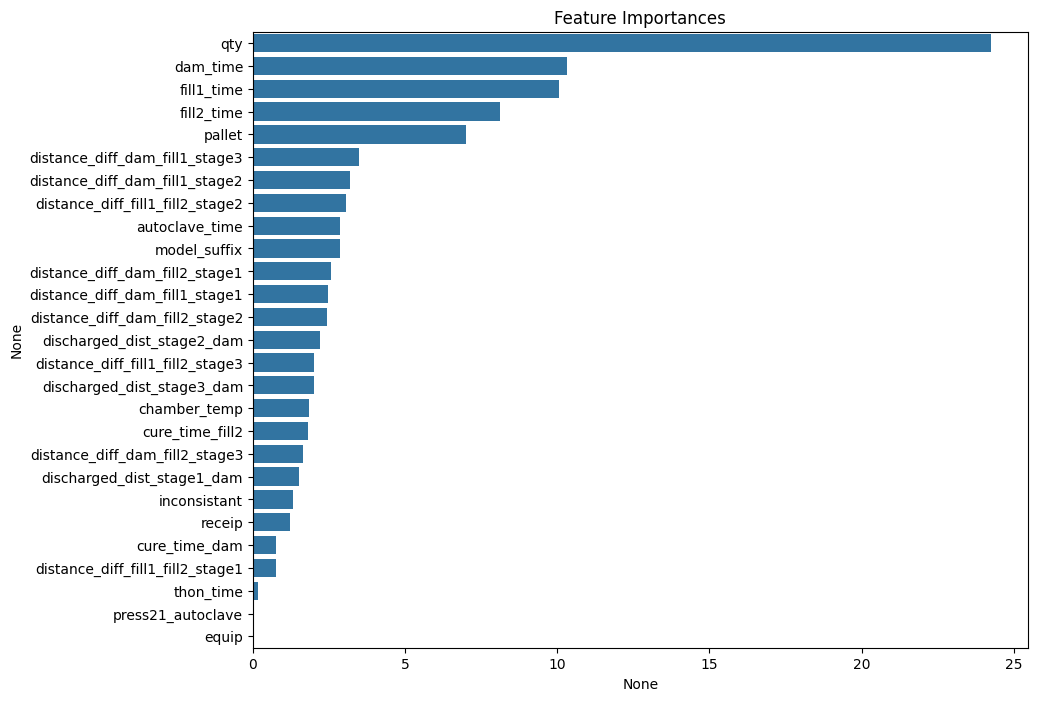

In [11]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [12]:
pred = best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  36  422]
 [  36 7608]]

정확도: 0.9435
정밀도: 0.5000
재현율: 0.0786
F1: 0.1358


# 추론

In [13]:
# 최적의 하이퍼파라미터로 모델 재학습
best_params = study.best_trial.params
best_model = CatBoostClassifier(**best_params)
best_model.fit(X, y)

0:	learn: 0.2386952	total: 29.3ms	remaining: 9.6s
1:	learn: 0.2128666	total: 58.4ms	remaining: 9.51s
2:	learn: 0.2088223	total: 87.4ms	remaining: 9.47s
3:	learn: 0.2052650	total: 116ms	remaining: 9.43s
4:	learn: 0.2043241	total: 146ms	remaining: 9.42s
5:	learn: 0.2036254	total: 176ms	remaining: 9.43s
6:	learn: 0.2024485	total: 205ms	remaining: 9.41s
7:	learn: 0.2023895	total: 228ms	remaining: 9.13s
8:	learn: 0.2022081	total: 259ms	remaining: 9.17s
9:	learn: 0.2017736	total: 288ms	remaining: 9.16s
10:	learn: 0.2013423	total: 317ms	remaining: 9.14s
11:	learn: 0.2011082	total: 346ms	remaining: 9.12s
12:	learn: 0.2009043	total: 375ms	remaining: 9.09s
13:	learn: 0.2005956	total: 405ms	remaining: 9.09s
14:	learn: 0.1996756	total: 435ms	remaining: 9.07s
15:	learn: 0.1990702	total: 464ms	remaining: 9.06s
16:	learn: 0.1984777	total: 495ms	remaining: 9.05s
17:	learn: 0.1978072	total: 524ms	remaining: 9.02s
18:	learn: 0.1972612	total: 552ms	remaining: 8.98s
19:	learn: 0.1962957	total: 582ms	remai

162:	learn: 0.1531779	total: 4.79s	remaining: 4.85s
163:	learn: 0.1530793	total: 4.82s	remaining: 4.82s
164:	learn: 0.1530072	total: 4.85s	remaining: 4.79s
165:	learn: 0.1528421	total: 4.88s	remaining: 4.76s
166:	learn: 0.1527236	total: 4.91s	remaining: 4.74s
167:	learn: 0.1524363	total: 4.94s	remaining: 4.71s
168:	learn: 0.1523495	total: 4.97s	remaining: 4.68s
169:	learn: 0.1521868	total: 5s	remaining: 4.65s
170:	learn: 0.1520271	total: 5.03s	remaining: 4.62s
171:	learn: 0.1519083	total: 5.06s	remaining: 4.59s
172:	learn: 0.1517789	total: 5.09s	remaining: 4.56s
173:	learn: 0.1517533	total: 5.12s	remaining: 4.53s
174:	learn: 0.1516659	total: 5.15s	remaining: 4.5s
175:	learn: 0.1514519	total: 5.18s	remaining: 4.47s
176:	learn: 0.1513164	total: 5.21s	remaining: 4.44s
177:	learn: 0.1511533	total: 5.24s	remaining: 4.41s
178:	learn: 0.1510607	total: 5.26s	remaining: 4.38s
179:	learn: 0.1508559	total: 5.29s	remaining: 4.35s
180:	learn: 0.1506216	total: 5.32s	remaining: 4.32s
181:	learn: 0.15

321:	learn: 0.1355947	total: 9.49s	remaining: 177ms
322:	learn: 0.1355940	total: 9.52s	remaining: 147ms
323:	learn: 0.1355111	total: 9.55s	remaining: 118ms
324:	learn: 0.1353926	total: 9.58s	remaining: 88.4ms
325:	learn: 0.1352725	total: 9.61s	remaining: 59ms
326:	learn: 0.1352596	total: 9.64s	remaining: 29.5ms
327:	learn: 0.1350942	total: 9.67s	remaining: 0us


In [14]:
# test x
test_x = test[X.columns]

In [15]:
test_pred = best_model.predict(test_x)
test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [16]:
y_pred = np.where(test_pred == 1, "AbNormal", "Normal")

In [17]:
np.unique(y_pred, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([  183, 17178]))

In [18]:
test['target'] = y_pred

In [19]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,155,17178
1,28,0


In [21]:
import shap

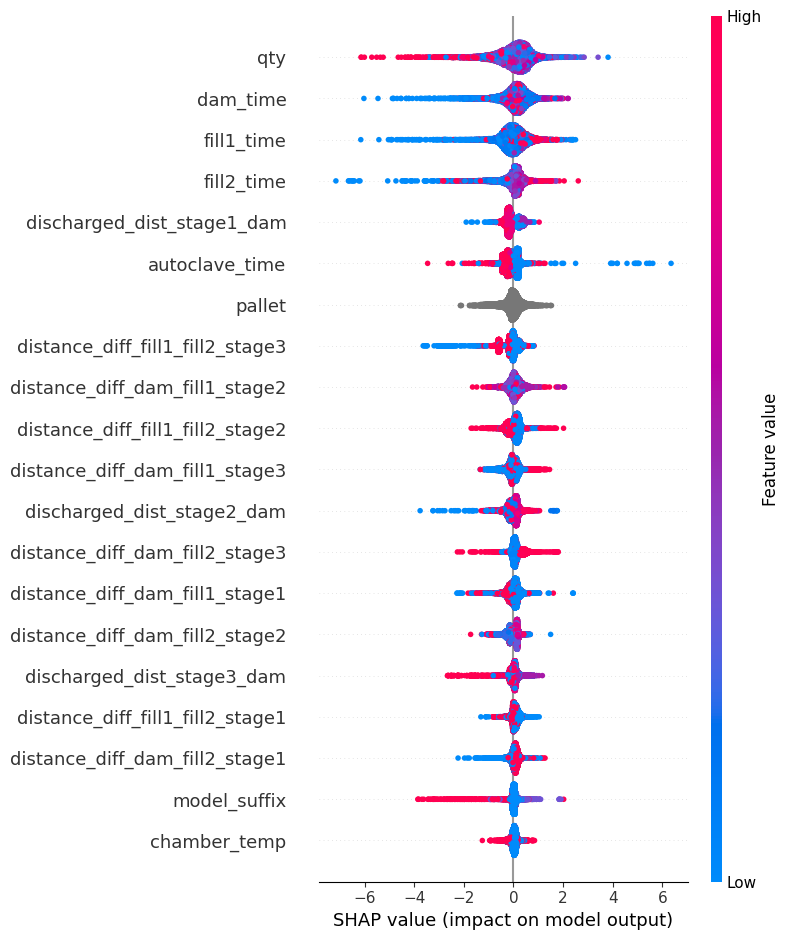

In [22]:
explainer = shap.Explainer(best_model)
shap_values = explainer(test_x)
shap.initjs()

shap.summary_plot(shap_values, test_x)

In [23]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = y_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)